# Function to read coefficients. 

In [1]:
%pylab inline
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


In [12]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [2]:
def read_coefficients(filename, nmax, lmax):
    """
    Function that reads BFE coefficients.
    
    Parameters:
    ------
    filename : str
        Filename with the coefficiens in which the first column is Snlm and the second column Tnlm
    nmax : int
        order of `n' in the expansion
    lmax : int
        order of `l' in the expansion
        
    Returns:
    -------
    Snlm : array_like
        Matrix with the Snlm coefficients with shape (nmax+1, lmax+1, lmax+1)
    Tnlm : array_like
        Matrix with the Tnlm coefficients with shape (nmax+1, lmax+1, lmax+1)
    """
    

    ST = np.loadtxt(filename)

    S = ST[:,0]
    T = ST[:,1]

    assert((nmax+1)*(lmax+1)*(lmax+1) == len(S)),\
            ' The values of nmax and lmax are inconsistnet with number of coefficints'

    S_nlm = S.reshape(nmax+1, lmax+1, lmax+1)
    T_nlm = T.reshape(nmax+1, lmax+1, lmax+1)

    return np.ascontiguousarray(S_nlm), np.ascontiguousarray(T_nlm)

In [3]:
Snlm, Tnlm = read_coefficients('../coefficients/ST_MWST_MWLMC6_beta0_100M_snap_000_n20_l5.txt', 20, 5)

In [4]:
def time_coefficients(filename, init_snap, final_snap, nmax, lmax):
    """
    Function that make a time dependent matrix with all the coefficients
    
    Parameters:
    ------
    filename : str
        Filename with the coefficiens in which the first column is Snlm and the second column Tnlm
    init_snap : int
        number of the initial coefficient file
    final_snap : int
        number of the final coefficient file
    nmax : int
        order of `n' in the expansion
    lmax : int
        order of `l' in the expansion
        
    Returns:
    -------
    Stnlm : array_like
        Matrix with the Snlm coefficients for all the times with shape (t, nmax+1, lmax+1, lmax+1)
    Ttnlm : array_like
        Matrix with the Tnlm coefficients for all the times with shape (t, nmax+1, lmax+1, lmax+1)
    """
        
    t = final_snap-init_snap 
    S_tnlm = np.zeros((t+1, nmax+1, lmax+1, lmax+1))
    T_tnlm = np.zeros((t+1, nmax+1, lmax+1, lmax+1))
    for i in range(init_snap, final_snap+1):
        ## to-do : Rename coefficients name to the format filename_000.txt
        S_tnlm[i-init_snap], T_tnlm[i-init_snap] = read_coefficients(filename+'{:0>3d}_n20_l5.txt'.format(i), nmax, lmax)
        
    return S_tnlm, T_tnlm

In [5]:
Stnlm, Ttnlm = time_coefficients('../coefficients/ST_MWST_MWLMC6_beta0_100M_snap_', 0, 20, 20, 5)

In [11]:
def interpolate_coeff(S, T, dt_nbody, dt_interp, time, nmax, lmax):
    """
    Interpolate the BFE coefficients.
    Parameters:
    -----------
        Stnlm : float
            The value of the cosine expansion coefficient for the
            desired number of snapshots to be interpolated.
        Ttnlm : float
            The value of the sine expansion coefficient for the
            desired number of snapshots to be interpolated.
        dt_nbody : float
            Time between snapshots in the n-body simulation.
        dt_interp : float
            dt for the interpolation.
        time: float
            Total time covered by the coefficients.
        nmax :
            Maximum value of ``n`` for the radial expansion.
        lmax :
            Maximum value of ``l`` for the spherical expansion.
    Returns:
    --------
        Snlm_interpolate : float
            The value of the cosine expansion coefficient interpolated
            for different dt values.
        Tnlm_interpolate : float
            The value of the sine expansion coefficient interpolated
            for different dt values.
    """

    # time arrays
    print(time, dt_nbody)
    time_array = np.arange(0, time+dt_nbody, dt_nbody)
    time_array_interp = np.arange(0, time+dt_interp, dt_interp)
    #print(time_array)
    #print(time_array_interp)

    ## Coefficient Matrix size: [time, nmax+1, lmax+1, lmax+1]
    S_interp = np.zeros((len(time_array_interp), nmax+1, lmax+1, lmax+1))
    T_interp = np.zeros((len(time_array_interp), nmax+1, lmax+1, lmax+1))
    # Interpolating the coefficients.
    # To-do see if 3d inter is possible to avoid the for loops.
    for i in range(nmax+1):
        for j in range(lmax+1):
            for k in range(j+1):
                fS = interpolate.interp1d(time_array, S[:,i,j,k])
                fT = interpolate.interp1d(time_array, T[:,i,j,k])
                S_interp[:,i,j,k] = fS(time_array_interp)
                T_interp[:,i,j,k] = fT(time_array_interp)
                
    return S_interp, T_interp


In [7]:
Sinterp, Tinterp = interpolate_coeff(Stnlm, Ttnlm, 0.02, 0.005, 0.4, 20, 5)

0.4 0.02


In [8]:
t_array = np.arange(0, 0.42, 0.02)
t_interp = np.arange(0, 0.405, 0.005)

Text(0,0.5,'$S_{000}$')

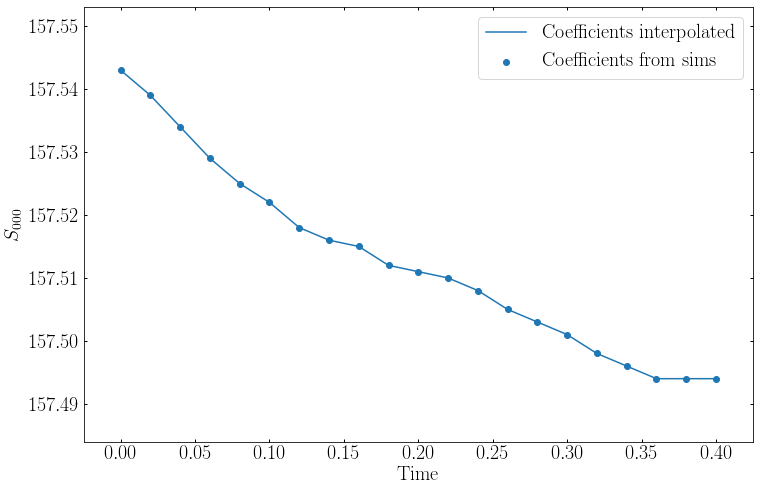

In [14]:
figsize(12, 8)
scatter(t_array, Stnlm[:, 0, 0, 0], label='Coefficients from sims')
plot(t_interp, Sinterp[:, 0, 0, 0], label='Coefficients interpolated')
legend()
xlabel(r'$\rm{Time}$')
ylabel('$S_{000}$')